In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import time
import xgboost as xgb

In [2]:
#Load the dataset, separate the labels from the training data
df1 = pd.read_csv('./../CSVfiles/ggH.csv')
df2 = pd.read_csv('./../CSVfiles/dataA.csv')
df3 = pd.read_csv('./../CSVfiles/dataB.csv')

df4 = pd.concat([df1, df2])
df = pd.concat([df4, df3])
y = df['label']
X = df.drop('label', axis = 1)

In [3]:
#Now we must do a train/test split on the data, shuffle too (this excludes mass currently)
x_train, x_test, y_train, y_test, m_train, m_test= train_test_split(df.iloc[:, 2:], df.iloc[:, 0],
                                                                    df.iloc[:,1], test_size=0.2, shuffle = True)

#Convert into DMatrix structure that XGBoost uses 
train_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
test_dmatrix = xgb.DMatrix(data=x_test,label=y_test)

In [4]:
#Now to fit the model to the training data
model = xgb.XGBClassifier()
training_start = time.perf_counter()
model.fit(x_train, y_train)
training_end = time.perf_counter()

C:\Users\jamie\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:54:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


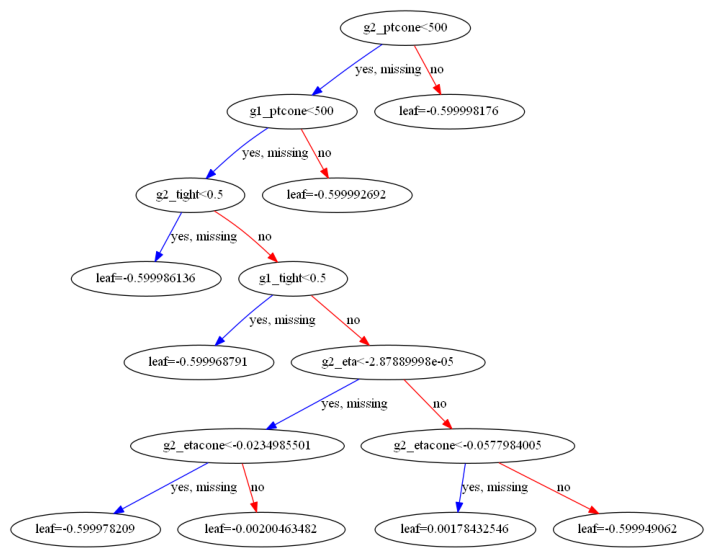

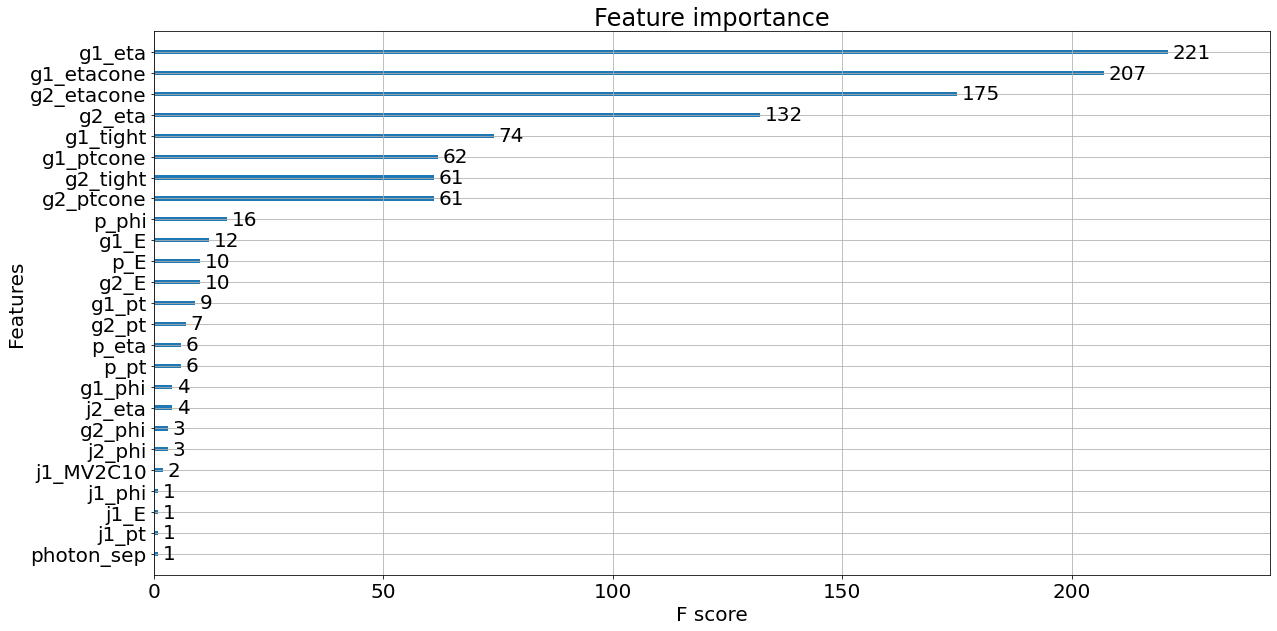

In [5]:
#Visualise one of the trees
plt.rcParams['figure.figsize'] = [100, 10]
xgb.plot_tree(model)
plt.show()

#Demonstrate the feature importances
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [20,10]
xgb.plot_importance(model)
plt.show()

In [6]:
#We can now use our testing set to make predictions
prediction_start = time.perf_counter()
predictions = model.predict(x_test)
prediction_end = time.perf_counter()
y_preds = np.rint(predictions)

Training time was: 190.36149449999994
Prediction time was: 0.48589670000001206
Number of correct predictions:  599172  and number of incorrect:  1
Accuracy: 100.00%


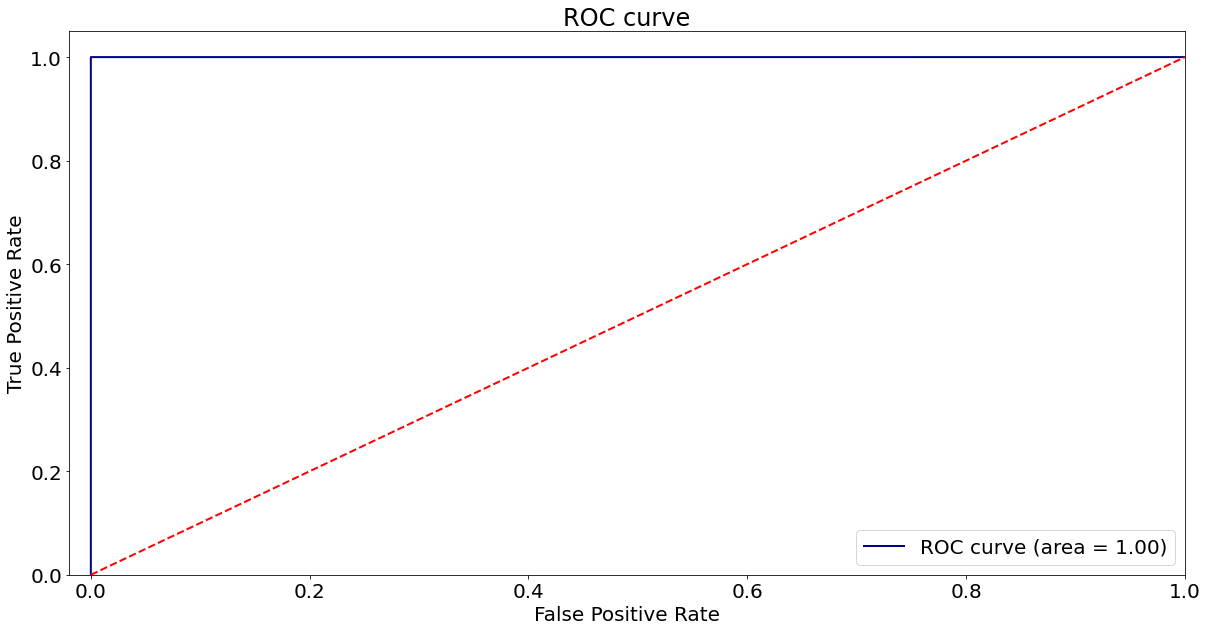

In [7]:
#Comparing the predictions to our original labels, we can
#evaluate how well the model performs

#Time efficiency
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print('Training time was: {}'.format(xgb_train_time))
print('Prediction time was: {}'.format(xgb_prediction_time))

tru = 0
fal = 0
for i in range(len(y_test.values)):
    if y_test.values[i] == y_preds[i]:
        tru += 1
    elif y_test.values[i] != y_preds[i]:
        fal += 1
    else:
        print('Uh oh')

print('Number of correct predictions: ', tru, ' and number of incorrect: ', fal)

#Show accuracy
accuracy = accuracy_score(y_test.values, y_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test.values, predictions)
roc_auc = auc(fpr, tpr)
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(fpr, tpr, color='darkblue',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

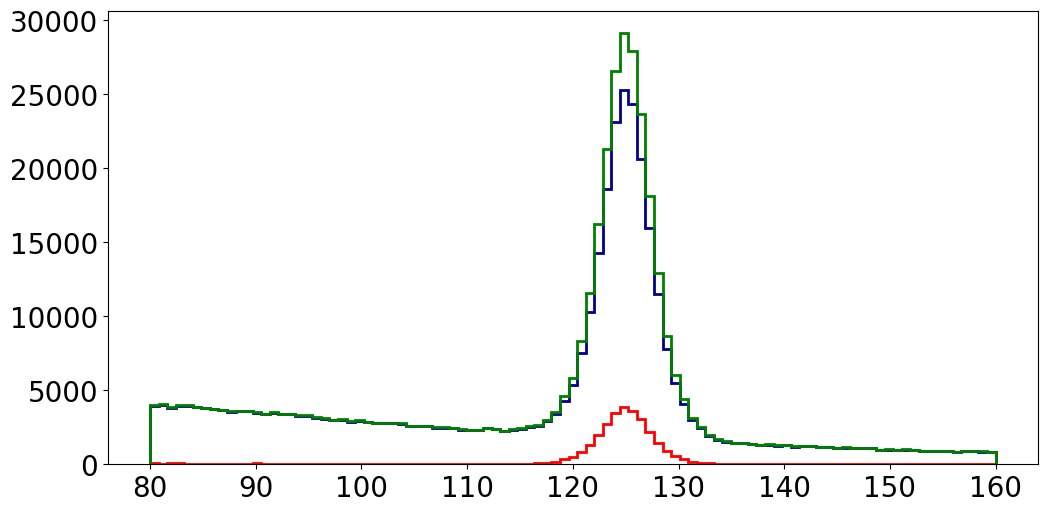

In [8]:
#Do a plot of the mass spectrum
plt.figure(figsize=(12,6), dpi= 100)
inv = m_test.values
preds = np.asarray(predictions)
sigs = inv[preds == 1]
bkgs = inv[preds == 0]
xlims=[80, 160]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkgs, color = 'darkblue', histtype='step',  bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step',  bins=bins,linewidth=2)
plt.hist(inv, color = 'green', histtype='step',  bins=bins,linewidth=2)
plt.show()